# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

This is a **supervised regression** task. The target variable is `price` (continuous), and the features include vehicle attributes such as year, manufacturer, model, condition, cylinders, fuel type, odometer reading, title status, transmission, drive type, size, vehicle type, and paint color, as well as geographic variables like region and state. Our goal is to fit regression models that predict price from these features, then interpret the learned coefficients and feature importances to identify which factors have the greatest positive or negative effect on a used car's market value. The success criterion is a model that generalizes well (measured via cross-validated error metrics such as RMSE and R²) and whose feature-level insights can be translated into clear, actionable inventory recommendations for the dealership.

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

*Step 1*: Read in the vehicles.csv file.


In [31]:
df = pd.read_csv('data/vehicles.csv')

# Display the first few rows of the dataset
print(f"df.head(): \n{df.head()}")
print(f"\n\n")
print(f"df.tail(): \n{df.tail()}")


df.head(): 
           id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN         Na

*Step 2*: Investigate the dataset for missing or problematic data.

In [32]:
# get number of rows and columns of dataframe
print("\nNumber of rows, columns:")
print(df.shape)


Number of rows, columns:
(426880, 18)


In [33]:
# data schema
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [34]:
# descriptive stats
print("\nDescriptive Statistics of Numerical Variables:")
df.describe()


Descriptive Statistics of Numerical Variables:


,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [35]:
# more descriptive stats
print("\nDescriptive Statistics of Categorical Variables")
df.describe(include=['object', 'category'])


Descriptive Statistics of Categorical Variables


,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
count,426880,409234,421603,252776,249202,423867,418638,424324,265838,296313,120519,334022,296677,426880
unique,404,42,29649,6,8,5,6,3,118246,3,4,13,12,51
top,columbus,ford,f-150,good,6 cylinders,gas,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,3608,70985,8009,121456,94169,356209,405117,336524,261,131904,63465,87056,79285,50614


In [36]:
# discover missing values in columns
print(df.isnull().sum())

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


*Step 3*: Decide what to do about your missing data -- drop, replace, other...

In [37]:
# "size" column has the most null values, so let's drop this column
df.drop('size', axis=1, inplace=True)
df.tail(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state
426870,7301592119,wyoming,22990,2020.0,hyundai,sonata se sedan 4d,good,NaN,gas,3066.0,clean,other,5NPEG4JAXLH051710,fwd,sedan,blue,wy
426871,7301591639,wyoming,17990,2018.0,kia,sportage lx sport utility 4d,good,NaN,gas,34239.0,clean,other,KNDPMCAC7J7417329,NaN,SUV,NaN,wy
426872,7301591201,wyoming,32590,2020.0,mercedes-benz,c-class c 300,good,NaN,gas,19059.0,clean,other,55SWF8DB6LU325050,rwd,sedan,white,wy
426873,7301591202,wyoming,30990,2018.0,mercedes-benz,glc 300 sport,good,NaN,gas,15080.0,clean,automatic,WDC0G4JB6JV019749,rwd,other,white,wy
426874,7301591199,wyoming,33590,2018.0,lexus,gs 350 sedan 4d,good,6 cylinders,gas,30814.0,clean,automatic,JTHBZ1BLXJA012999,rwd,sedan,white,wy
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,sedan,silver,wy
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,coupe,NaN,wy


*Step 4*: Peek at correlation matrix


Text(0.5, 1.0, 'Correlation Matrix Heatmap')

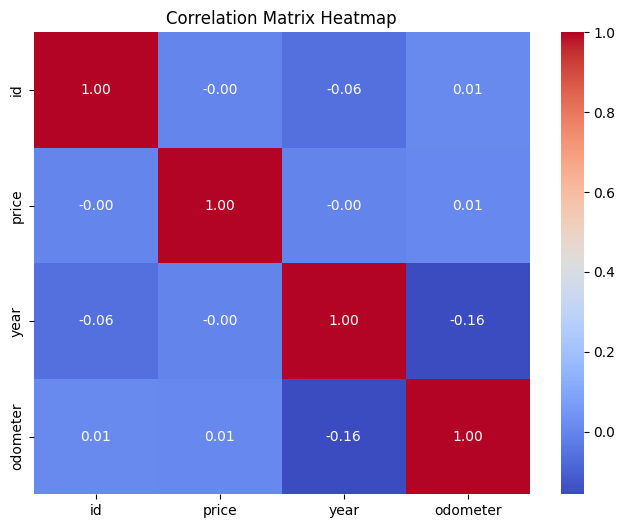

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Generate the Heatmap
# Use seaborn's heatmap() function, passing the corr_matrix as the primary argument.

# Set up the matplotlib figure and axes
f, ax = plt.subplots(figsize=(8, 6))

# Draw the heatmap with annotation
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)

# Add a title
plt.title('Correlation Matrix Heatmap')

*Step 5*: Let's take a peek on the distrution of all numeric and non-numeric features

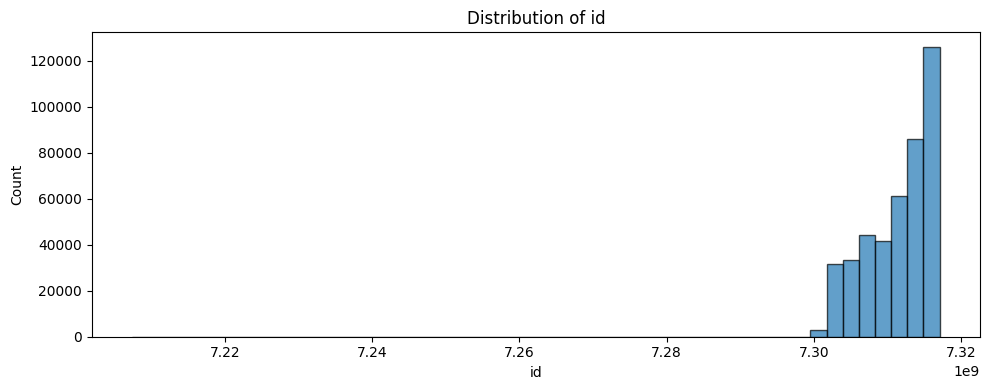

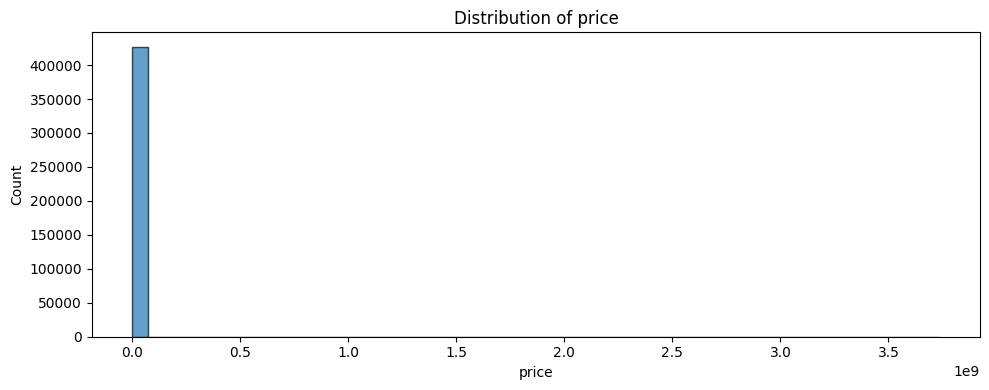

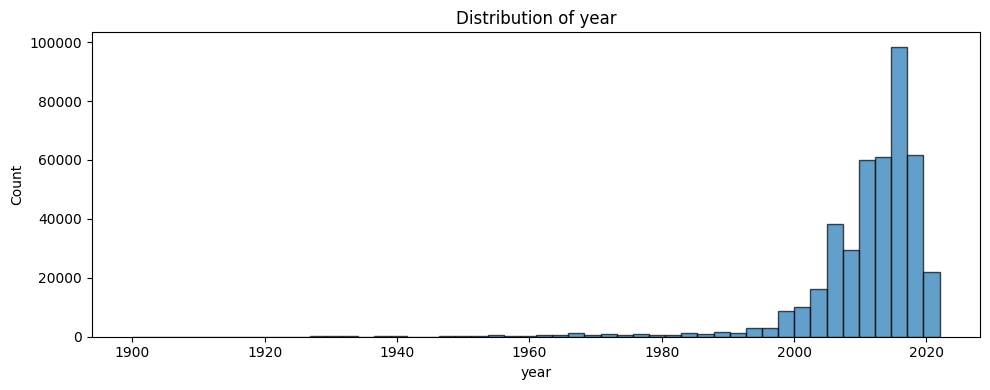

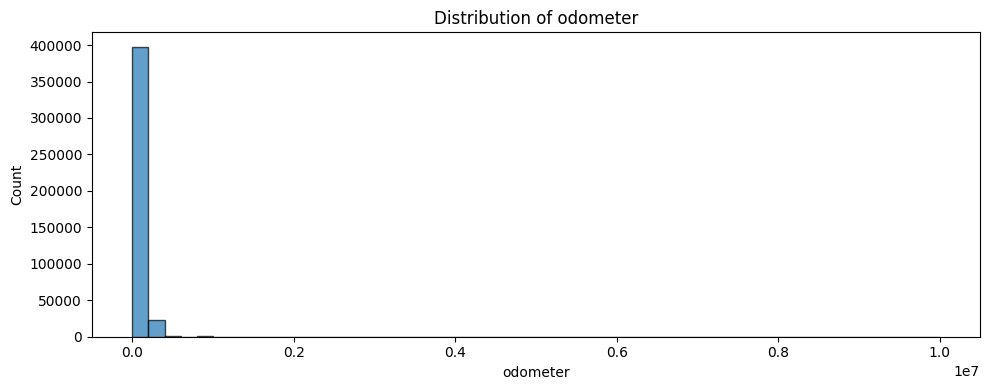

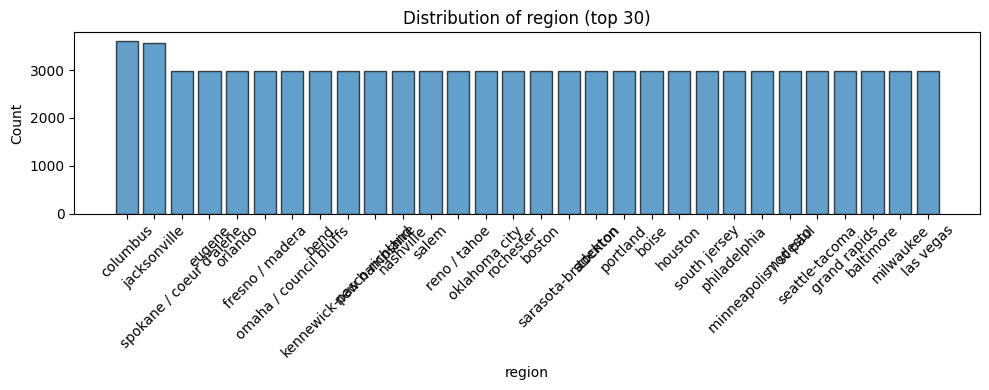

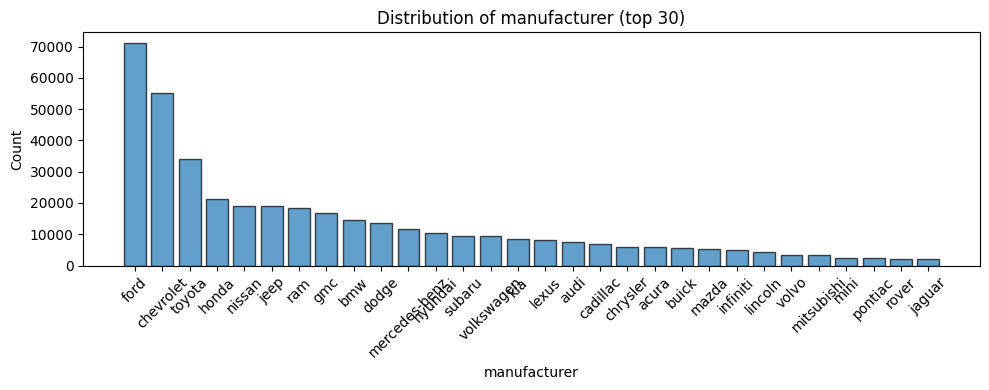

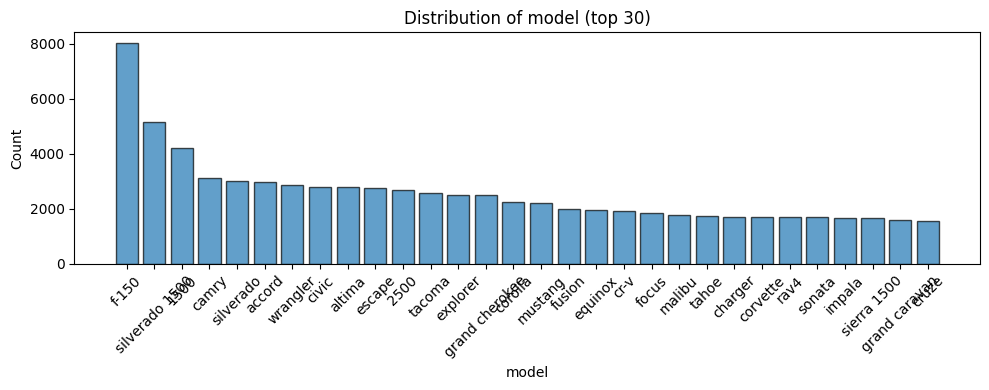

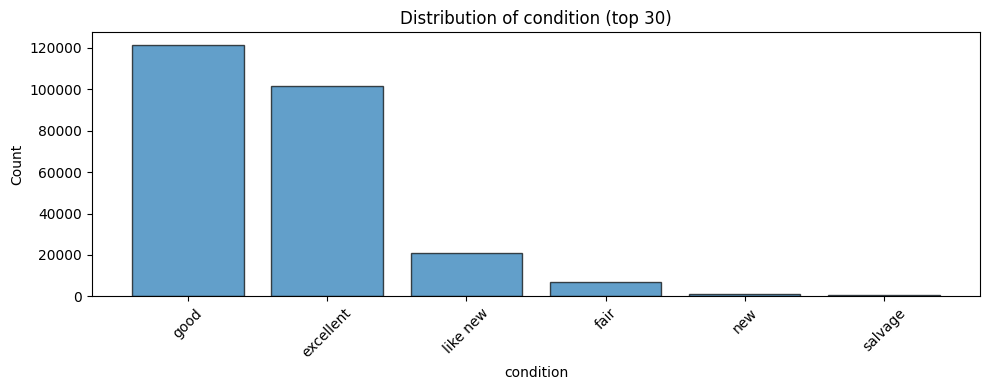

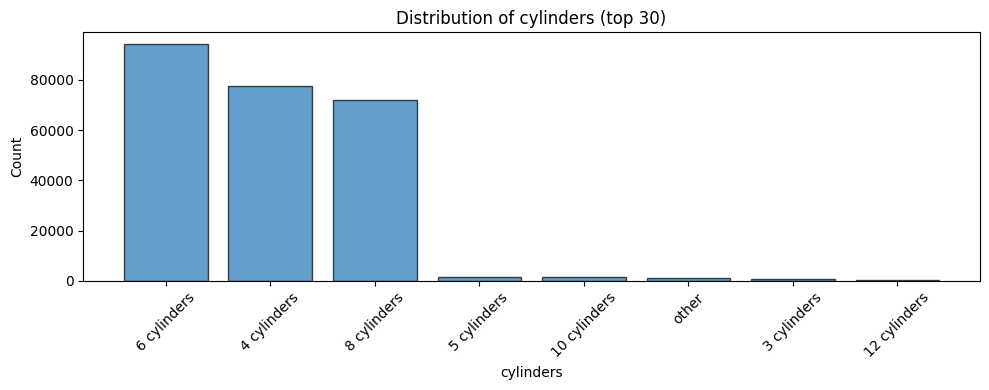

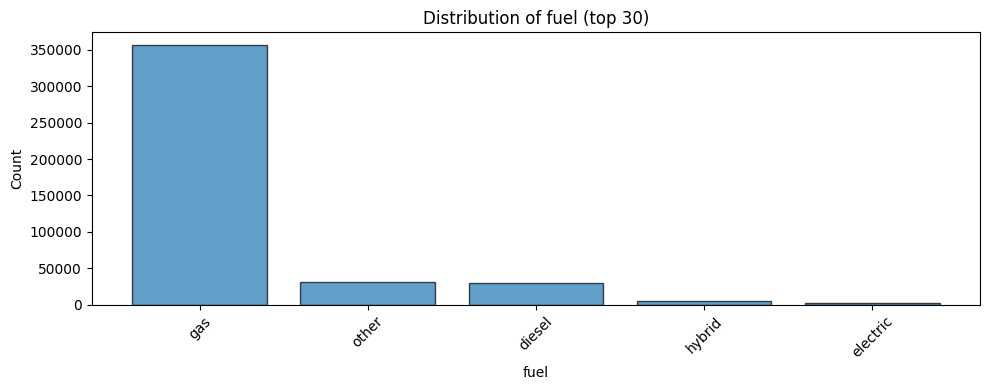

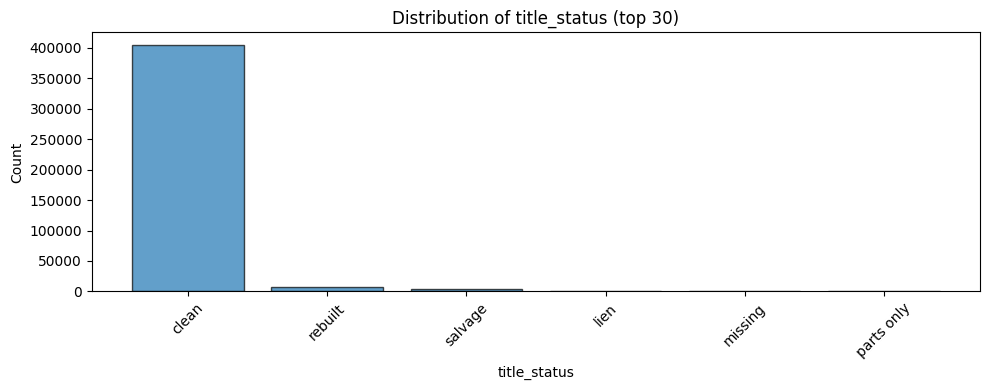

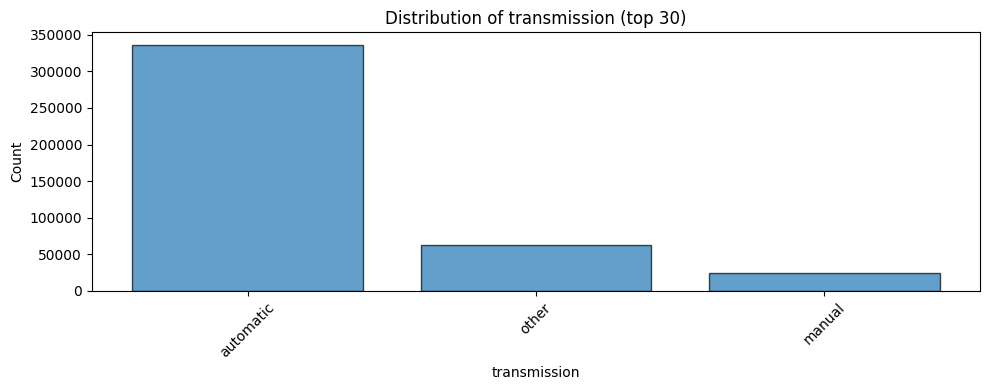

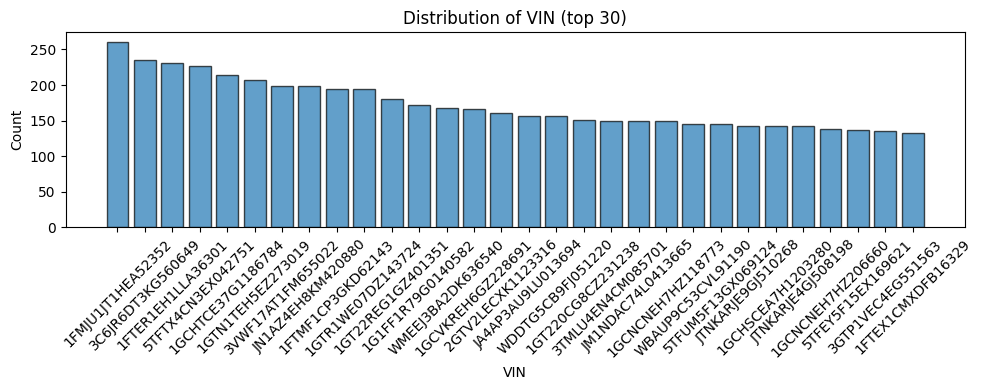

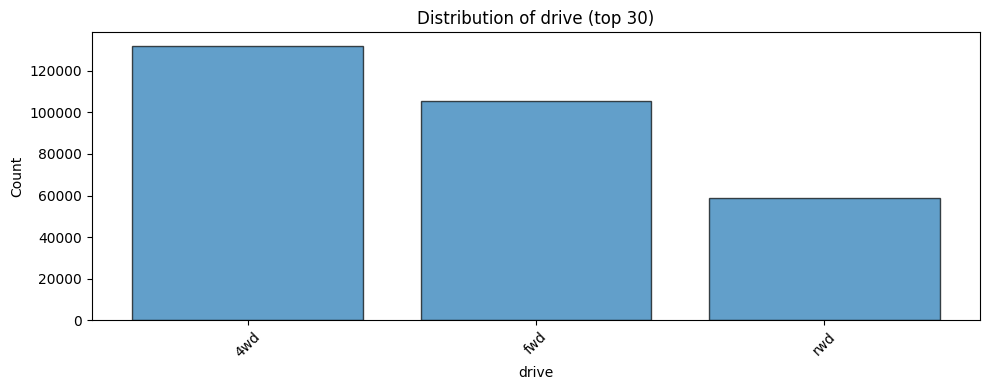

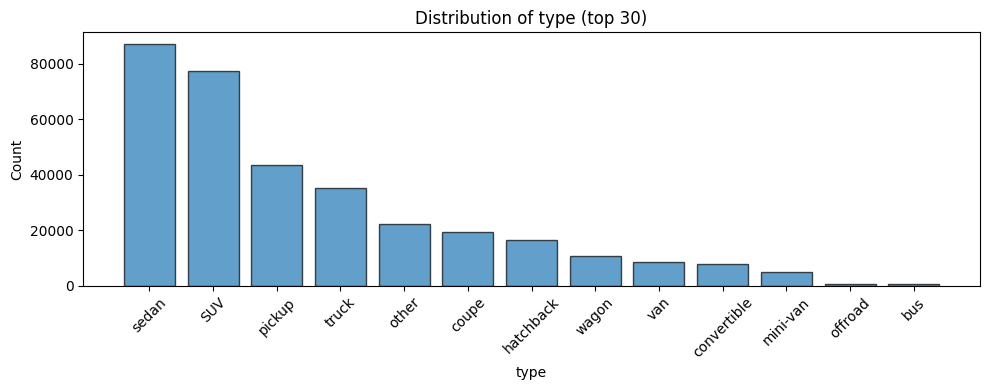

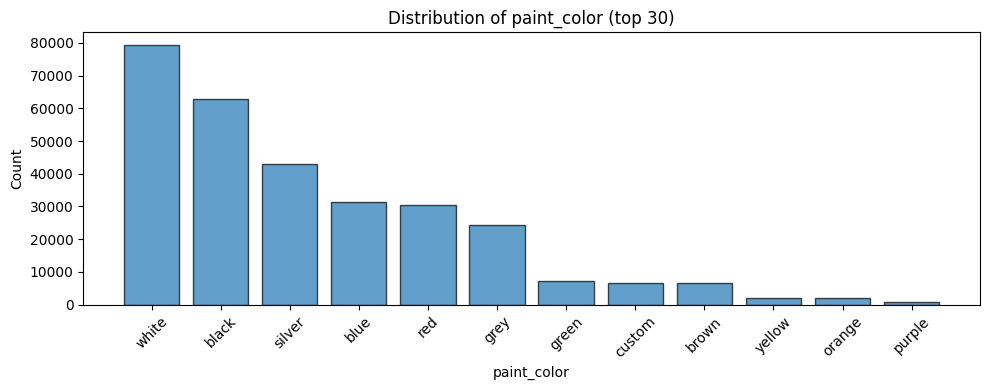

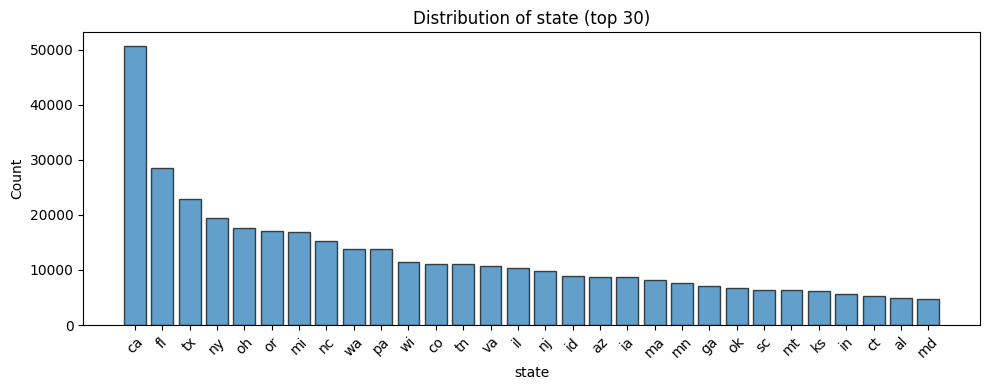

In [39]:
numeric_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

for col in numeric_cols:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()

for col in categorical_cols:
    counts = df[col].value_counts().nlargest(30)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(counts.index.astype(str), counts.values, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {col} (top 30)')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [40]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

print(f"Shape before cleaning: {df.shape}")

# Drop columns not useful for modeling
df = df.drop(columns=['id', 'VIN', 'region'], errors='ignore')

# Remove price outliers (keep $500 - $100,000)
df = df[df['price'].between(500, 100_000)]

# Remove unrealistic years and odometer readings
df = df[df['year'] >= 1990]
df = df[df['odometer'] <= 300_000]

print(f"Shape after removing outliers: {df.shape}")

Shape before cleaning: (426880, 17)
Shape after removing outliers: (366814, 14)


In [41]:
# Drop rows missing critical fields
df = df.dropna(subset=['year', 'manufacturer', 'odometer', 'fuel', 'transmission', 'title_status'])

# Fill remaining categorical NaNs with 'unknown'
cat_cols = ['model', 'condition', 'cylinders', 'drive', 'type', 'paint_color']
for col in cat_cols:
    df[col] = df[col].fillna('unknown')

print(f"Shape after handling missing values: {df.shape}")
print(f"\nRemaining nulls:\n{df.isnull().sum()}")

Shape after handling missing values: (346112, 14)

Remaining nulls:
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
dtype: int64


In [42]:
# Create 'vehicle_age' feature
df['vehicle_age'] = 2025 - df['year']
df = df.drop(columns=['year'])

# Convert 'cylinders' from string to numeric
cyl_map = {
    '3 cylinders': 3, '4 cylinders': 4, '5 cylinders': 5,
    '6 cylinders': 6, '8 cylinders': 8, '10 cylinders': 10,
    '12 cylinders': 12, 'other': 0, 'unknown': 0
}
df['cylinders'] = df['cylinders'].map(cyl_map).fillna(0).astype(int)

# Drop 'model' — too many unique values (high cardinality) for encoding
df = df.drop(columns=['model'])

print(f"Shape after feature engineering: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Shape after feature engineering: (346112, 13)

Columns: ['price', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state', 'vehicle_age']


,price,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,vehicle_age
27,33590,gmc,good,8,gas,57923.0,clean,other,unknown,pickup,white,al,11.0
28,22590,chevrolet,good,8,gas,71229.0,clean,other,unknown,pickup,blue,al,15.0
29,39590,chevrolet,good,8,gas,19160.0,clean,other,unknown,pickup,red,al,5.0
30,30990,toyota,good,8,gas,41124.0,clean,other,unknown,pickup,red,al,8.0
31,15000,ford,excellent,6,gas,128000.0,clean,automatic,rwd,truck,black,al,12.0


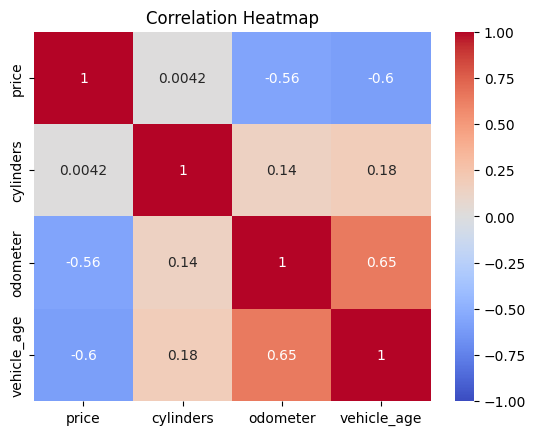

In [45]:
#Another heatmap

df_numeric = df.select_dtypes(include=['float64', 'int64'])
# Heatmap on numerical features
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Heatmap')

plt.show()

Scatter plot of odometer values, vehicle age, and vehicle price

In [ ]:
# plot the scatter plot
plt.scatter(df['odometer'], df['vehicle_age'], cmap='viridis')
plt.xlabel('Odometer')
plt.ylabel('Vehicle Age')
plt.title('Scatter Plot of Odometer vs Vehicle Age')
plt.colorbar(label='Price')
plt.show()



KeyError: 'price'

* One-hot encodes all remaining categorical features (manufacturer, condition, fuel, title_status, transmission, drive, type, paint_color, state)
* Scales numeric features (odometer, cylinders, vehicle_age) with StandardScaler
* Splits into 80/20 train/test sets (X_train, X_test, y_train, y_test)


In [ ]:
# Separate target from features
y = df['price']
X = df.drop(columns=['price'])

# One-hot encode categorical features
cat_features = X.select_dtypes(include='object').columns.tolist()
num_features = X.select_dtypes(include='number').columns.tolist()

print(f"Categorical features to encode: {cat_features}")
print(f"Numeric features: {num_features}")

X = pd.get_dummies(X, columns=cat_features, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


Categorical features to encode: ['manufacturer', 'condition', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']
Numeric features: ['cylinders', 'odometer', 'vehicle_age']

Final feature matrix shape: (346112, 138)
X_train: (276889, 138), X_test: (69223, 138)
y_train: (276889,), y_test: (69223,)


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# create a ridge regression model to predict price
model = Ridge().fit(X_train, y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)


train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')



Train MSE: 62751386.82079814
Test MSE: 61189668.00492155


In [ ]:
from sklearn.inspection import permutation_importance
import plotly.express as px


perm_importance = permutation_importance(
    model, 
    X_train, 
    y_train, 
    n_repeats=3,       # Reduced from 10
    n_jobs=-1,         # Uses all CPU cores
    #max_samples=10000  # Scores on 10k random rows instead of 277k
)

df2 = pd.DataFrame(perm_importance['importances'])
df3 = df2.T
df3.columns = X_train.columns

px.box(data_frame=df3, orientation='v', title = 'Feature importance for price prediction')



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'variable=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa'},
              'name': '',
              'notched': False,
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'box',
              'x': array(['cylinders', 'cylinders', 'cylinders', ..., 'state_wy', 'state_wy',
                          'state_wy'], dtype=object),
              'x0': ' ',
              'xaxis': 'x',
              'y': array([4.78915306e-03, 4.53300197e-03, 4.84442743e-03, ..., 1.65962583e-06,
                          6.42079717e-06, 3.70626710e-06]),
              'y0': ' ',
              'yaxis': 'y'}],
    'layout': {'boxmode': 'group',
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Categorical Feature importance for price prediction'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'variable'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'value'}}}
})

In [60]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


# Create a dictionary
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

# Create a pipeline
pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

# Create a GridSearchCV object
grid_2 = GridSearchCV(pipe, param_grid=param_dict)

# Fit the GridSearchCV object on the training data
grid_2.fit(X_train, y_train)

# Make predictions on the training and test sets
train_preds = grid_2.predict(X_train)
test_preds = grid_2.predict(X_test)

# Calculate the MSE for the training and test sets
model_2_train_mse = mean_squared_error(y_train, train_preds)
model_2_test_mse = mean_squared_error(y_test, test_preds)
model_2_best_alpha = grid_2.best_params_


# check the results
print(f'Test MSE: {model_2_test_mse}')
print(f'Train MSE: {model_2_train_mse}')
print(f'Best Alpha: {list(model_2_best_alpha.values())[0]}')




Test MSE: 61183631.093204655
Train MSE: 62750711.60468538
Best Alpha: 100.0


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.